In [4]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from IPython import display as ipythondisplay

from utils import get_trajectory, get_position, my_odometry

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.2.38 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:nodes:version 6.2.13 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages pyparsing 3.0.6
DEBUG:gym-duckietown:gym-duckietown version 6.1.30 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'advanced_font_features': False, 'headless': False, 'headless_device': 0}


In [5]:
plt.rcParams['figure.figsize'] = [7, 7]

In [6]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [7]:
env = Simulator("small_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[1,0],
    seed=42,
    max_steps=float("inf"),
)

INFO:duckietown_world: data: /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages/duckietown_world/data


In [8]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], 0]

In [9]:
env.reset()
traj = get_trajectory(env)

/home/giulio/prog/duckrace_simulator/utils.py:170: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


In [10]:
traj[:10]

array([[1.47224186, 0.89882168],
       [1.46327478, 0.99399287],
       [1.46667284, 1.09337466],
       [1.47114545, 1.19275645],
       [1.47026898, 1.28107248],
       [1.44334587, 1.36818113],
       [1.39329816, 1.42978918],
       [1.32102126, 1.4597663 ],
       [1.24019591, 1.4699859 ],
       [1.14303777, 1.47681769]])

In [11]:
pose = get_position(env)
pose

Position(x=0.7019999, y=1.34470641, theta=0.0)

In [12]:
from scipy import spatial

In [13]:
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])

In [14]:
traj[index]

array([0.72770678, 1.47150851])

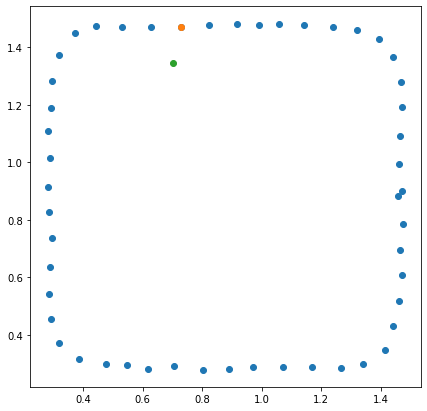

In [15]:
# Rotate the trajectory so that the agent is facing the same direction as the trajectory
plt.scatter(*traj.T)
plt.scatter(*traj[index])
plt.scatter(pose.x, pose.y)

In [16]:
from scipy.optimize import minimize

In [24]:
def mpc_loss(u, N, x0, y0, theta0, v0, w0, closest_index, Q, R, dt):
    """
    L(u) = sum_{t=0}^{N-1} Q * ||x_o_t - x_t||^2 + R * ||u_t||^2
    """
    loss = 0
    for t in range(N-1):
        p, v0, w0 = my_odometry(u[t], x0, y0, theta0, v0, w0, dt=dt)
        loss += Q * ((p.x - traj[closest_index,0])**2 + (p.y - traj[closest_index,1])**2) + R * (u[t][0]**2 + u[t][1]**2)
    return loss


TypeError: mpc_loss() missing 1 required positional argument: 'delay'

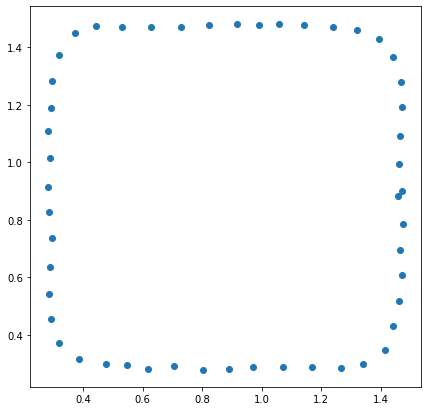

In [32]:
N = 10
Q, R = 1, 1

horizon_len = 4
simulation_len = 20

delta_time = 1.0 / env.frame_rate
delay = round(0.15/delta_time)
delay = 1
phi = 1

horizon_len = horizon_len * 2

bnds = list(((-1, 1) for _ in range(horizon_len)))

env.reset()
pose = get_position(env)
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
index = index - 3
plt.scatter(*traj.T)
actions = [[0,0] for _ in range(delay)]
loss_val = []
odoms = [pose]
poses = []
v0, w0, = 0, 0
env.reset()

u = np.random.standard_normal(horizon_len)
res = minimize(mpc_loss, u, args=(N, pose.x, pose.y, pose.theta, v0, w0, index, Q, R, delta_time), method="L-BFGS-B", bounds=bnds)

for i in range(delay+horizon_len):
    action = np.concatenate(([0,0]*delay, res.x.reshape(-1, 2)))[i]
    actions.append(action)
    env.step(action)
    pose = get_position(env)
    poses.append(pose)
    plt.scatter(pose.x, pose.y, c='r')